# 📝 User Story to Development Tasks Pipeline

Este notebook genera tareas de desarrollo a partir de historias de usuario usando Simple Pipeline y Ollama.

## 📋 Objetivo
- **Input**: Historias de usuario con columna `input` (JSON con project, summary, description)
- **Output**: Lista de tareas de desarrollo para cada historia

## 🔄 Pipeline
1. Cargar dataset de historias de usuario
2. Generar tareas con Ollama usando prompt específico
3. Post-procesar y parsear resultados
4. Analizar y exportar

## 1. Setup e Imports

In [23]:
import pandas as pd
import json
import re
import sys
from pathlib import Path
from typing import Dict, List
import matplotlib.pyplot as plt
import seaborn as sns

# Agregar el directorio padre al path
sys.path.insert(0, str(Path.cwd().parent))

from simple_pipeline import SimplePipeline
from simple_pipeline.steps import (
    LoadDataFrame,
    RobustOllamaStep,
    OllamaLLMStep,
    KeepColumns
)

# Configurar visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Imports completados")

✅ Imports completados


## 2. Cargar Dataset

**Importante**: Tu dataset debe tener una columna `input` con JSON en formato:
```json
{
  "project": "Nombre del proyecto",
  "summary": "Resumen de la historia",
  "description": "Descripción detallada"
}
```

In [24]:
# Opción 1: Cargar tu dataset existente
# df = pd.read_csv('path/to/your/user_stories.csv')

# Opción 2: Crear dataset de ejemplo
sample_user_stories = [
    {
        "input": json.dumps({
            "project": "E-commerce Platform",
            "summary": "User login with email and password",
            "description": "As a user, I want to log in to the platform using my email and password so that I can access my account and make purchases. The system should validate credentials, handle errors gracefully, and provide password recovery options."
        })
    },
    {
        "input": json.dumps({
            "project": "Task Management App",
            "summary": "Create and assign tasks to team members",
            "description": "As a project manager, I want to create tasks and assign them to specific team members so that work can be distributed effectively. Each task should have a title, description, due date, priority level, and assignee. The system should send notifications to assigned members."
        })
    },
    {
        "input": json.dumps({
            "project": "Social Media Dashboard",
            "summary": "Display analytics for social media posts",
            "description": "As a social media manager, I want to view analytics for all my posts including likes, comments, shares, and reach so that I can measure engagement. The dashboard should support filtering by date range, platform, and post type, with exportable reports."
        })
    },
    {
        "input": json.dumps({
            "project": "Healthcare Portal",
            "summary": "Schedule medical appointments online",
            "description": "As a patient, I want to schedule medical appointments online so that I don't have to call the clinic. The system should show available time slots, allow me to select my preferred doctor, send confirmation emails, and provide reminders before the appointment."
        })
    },
    {
        "input": json.dumps({
            "project": "Inventory Management System",
            "summary": "Track product stock levels and reorder automatically",
            "description": "As a warehouse manager, I want the system to automatically track stock levels and trigger reorder alerts when inventory falls below minimum thresholds. The system should integrate with suppliers, generate purchase orders, and maintain a complete audit trail of all inventory movements."
        })
    }
]

df = pd.DataFrame(sample_user_stories)

print(f"✅ Dataset cargado: {len(df)} historias de usuario")
print(f"\nColumnas: {list(df.columns)}")
print(f"\nPrimera historia (raw):")
print(df['input'].iloc[0][:200] + "...")

✅ Dataset cargado: 5 historias de usuario

Columnas: ['input']

Primera historia (raw):
{"project": "E-commerce Platform", "summary": "User login with email and password", "description": "As a user, I want to log in to the platform using my email and password so that I can access my acco...


In [25]:
# Parsear el JSON para vista previa
def parse_user_story(input_str: str) -> Dict:
    try:
        return json.loads(input_str)
    except:
        return {"project": "Unknown", "summary": "Unknown", "description": input_str}

parsed_stories = df['input'].apply(parse_user_story)
df['project'] = parsed_stories.apply(lambda x: x['project'])
df['summary'] = parsed_stories.apply(lambda x: x['summary'])
df['description_preview'] = parsed_stories.apply(lambda x: x['description'][:100] + '...')

print("📊 Vista previa del dataset:")
display(df[['project', 'summary', 'description_preview']])

📊 Vista previa del dataset:


,project,summary,description_preview
0,E-commerce Platform,User login with email and password,"As a user, I want to log in to the platform us..."
1,Task Management App,Create and assign tasks to team members,"As a project manager, I want to create tasks a..."
2,Social Media Dashboard,Display analytics for social media posts,"As a social media manager, I want to view anal..."
3,Healthcare Portal,Schedule medical appointments online,"As a patient, I want to schedule medical appoi..."
4,Inventory Management System,Track product stock levels and reorder automat...,"As a warehouse manager, I want the system to a..."


## 3. Definir Prompt Template

Este es el prompt exacto que especificaste.

In [26]:
def create_task_generation_prompt(row: Dict) -> str:
    """
    Crea el prompt para generar tareas a partir de una historia de usuario.
    
    Args:
        row: Fila del DataFrame con la columna 'input' que contiene el JSON
    
    Returns:
        Prompt formateado según tu especificación
    """
    # Parsear el input JSON
    try:
        user_story = json.loads(row['input'])
        project = user_story.get('project', 'Unknown Project')
        summary = user_story.get('summary', 'No summary')
        description = user_story.get('description', 'No description')
    except Exception as e:
        return f"Error parsing user story: {e}"
    
    # Construir el prompt EXACTO que especificaste
    prompt = f"""Below is an instruction that describes a task, paired with an input that provides a user story with this format:
"project": "Name of the project"
"summary": "Summary of the user story"
"description": "Description of the user story"

Write a response that appropriately completes the request.


Instruction:


Break this user story into smaller development tasks to help the developers implement it efficiently. You can divide this user story into as many tasks as needed, depending on its complexity. Each task must be unique, actionable, and non-overlapping.

Use the following format for the response:

1. summary: ‹task summary 1›
description: ‹task description 1›
2. summary: ‹task summary 2›
description: ‹task description 2›


N. summary: ‹task summary N›
description: ‹task description N›


Input:


project: {project}
summary: {summary}
description: {description}


Response:"""
    
    return prompt

# Probar el prompt con la primera historia
test_prompt = create_task_generation_prompt(df.iloc[0].to_dict())
print("📝 Ejemplo de prompt generado:")
print("="*80)
print(test_prompt)
print("="*80)

📝 Ejemplo de prompt generado:
Below is an instruction that describes a task, paired with an input that provides a user story with this format:
"project": "Name of the project"
"summary": "Summary of the user story"
"description": "Description of the user story"

Write a response that appropriately completes the request.


Instruction:


Break this user story into smaller development tasks to help the developers implement it efficiently. You can divide this user story into as many tasks as needed, depending on its complexity. Each task must be unique, actionable, and non-overlapping.

Use the following format for the response:

1. summary: ‹task summary 1›
description: ‹task description 1›
2. summary: ‹task summary 2›
description: ‹task description 2›


N. summary: ‹task summary N›
description: ‹task description N›


Input:


project: E-commerce Platform
summary: User login with email and password
description: As a user, I want to log in to the platform using my email and password so th

## 4. Configurar Pipeline

In [27]:
# Configuración del modelo y pipeline
CONFIG = {
    'model_name': 'llama3.1:8b',  # Cambia según tu modelo Ollama
    'batch_size': 2,           # Historias procesadas simultáneamente
    'temperature': 0.7,
    'num_predict': 1000,       # Tokens máximos (tareas pueden ser largas)
}

print("⚙️ Configuración:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

⚙️ Configuración:
  model_name: llama3.1:8b
  batch_size: 2
  temperature: 0.7
  num_predict: 1000


In [28]:
# Crear pipeline
pipeline = SimplePipeline(
    name="user-story-to-tasks",
    description="Genera tareas de desarrollo a partir de historias de usuario",
    log_level="INFO"
)

# Step 1: Cargar datos (solo columna input)
pipeline.add_step(
    LoadDataFrame(
        name="load_user_stories",
        df=df[['input']]
    )
)

# Step 2: Generar tareas con Ollama
pipeline.add_step(
    OllamaLLMStep(
        name="generate_tasks",
        model_name=CONFIG['model_name'],
        prompt_column="input",
        output_column="tasks_raw",
        prompt_template=create_task_generation_prompt,
        system_prompt="You are an expert software development lead who excels at breaking down user stories into clear, actionable development tasks. Be specific and practical.",
        batch_size=CONFIG['batch_size'],
        generation_kwargs={
            "temperature": CONFIG['temperature'],
            "num_predict": CONFIG['num_predict']
        },
    )
)

print(f"\n✅ Pipeline configurado con {len(pipeline.steps)} steps")

2025-10-16 23:28:38 - SimplePipeline.user-story-to-tasks - INFO - Added step: load_user_stories
2025-10-16 23:28:38 - SimplePipeline.user-story-to-tasks - INFO - Added step: generate_tasks



✅ Pipeline configurado con 2 steps


## 5. Ejecutar Pipeline

⏱️ Esto puede tomar varios minutos dependiendo del tamaño del dataset y el modelo.

In [29]:
print("🚀 Ejecutando pipeline...\n")
print("="*80)

result_df = pipeline.run(use_cache=False)

print("="*80)
print("\n✅ Pipeline completado!")
print(f"   Historias procesadas: {len(result_df)}")
print(f"   Columnas: {list(result_df.columns)}")

2025-10-16 23:28:38 - SimplePipeline.user-story-to-tasks - INFO - Starting pipeline: user-story-to-tasks
2025-10-16 23:28:38 - SimplePipeline.user-story-to-tasks - INFO - Number of steps: 2
2025-10-16 23:28:38 - SimplePipeline.user-story-to-tasks - INFO - Executing generator step: load_user_stories
2025-10-16 23:28:38 - SimplePipeline.user-story-to-tasks - INFO - Executing step: generate_tasks


🚀 Ejecutando pipeline...



Processing generate_tasks: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]
2025-10-16 23:28:54 - SimplePipeline.user-story-to-tasks - INFO -   ✓ Complete (5 rows, 3 columns)
2025-10-16 23:28:54 - SimplePipeline.user-story-to-tasks - INFO - Pipeline execution complete!



✅ Pipeline completado!
   Historias procesadas: 5
   Columnas: ['input', 'tasks_raw', 'model_name']


In [30]:
result_df

,input,tasks_raw,model_name
0,"{""project"": ""E-commerce Platform"", ""summary"": ...",Here are the development tasks broken down fro...,llama3.1:8b
1,"{""project"": ""Task Management App"", ""summary"": ...",That's a comprehensive user story! Here are th...,llama3.1:8b
2,"{""project"": ""Social Media Dashboard"", ""summary...",Development Tasks,llama3.1:8b
3,"{""project"": ""Healthcare Portal"", ""summary"": ""S...",Development Tasks for 'Schedule medical appoin...,llama3.1:8b
4,"{""project"": ""Inventory Management System"", ""su...",Here are the broken-down development tasks for...,llama3.1:8b


## 6. Verificar Resultados

In [31]:
# Separar exitosos y fallidos
successful = result_df[result_df['status'] == 'success'].copy()
failed = result_df[result_df['status'] == 'failed'].copy()

print(f"📊 Resumen de Ejecución:")
print(f"   ✅ Exitosos: {len(successful)} ({len(successful)/len(result_df)*100:.1f}%)")
print(f"   ❌ Fallidos: {len(failed)} ({len(failed)/len(result_df)*100:.1f}%)")

if len(failed) > 0:
    print(f"\n⚠️ Errores encontrados:")
    for idx, row in failed.iterrows():
        print(f"   Historia {idx}: {str(row['error'])[:80]}")
    print(f"\n   Ver detalles en: ../failures/")

KeyError: 'status'

## 7. Post-Procesamiento

Parseamos las tareas del formato de respuesta.

In [ ]:
def parse_tasks_from_response(response_text: str) -> List[Dict[str, str]]:
    """
    Parsea las tareas del formato especificado.
    
    Formato esperado:
    1. summary: task summary 1
    description: task description 1
    
    2. summary: task summary 2
    description: task description 2
    """
    tasks = []
    
    if not response_text or pd.isna(response_text):
        return tasks
    
    # Pattern para encontrar tareas numeradas
    pattern = r'(\d+)\.\s*summary:\s*(.+?)\s*description:\s*(.+?)(?=\d+\.\s*summary:|$)'
    
    matches = re.finditer(pattern, response_text, re.IGNORECASE | re.DOTALL)
    
    for match in matches:
        task_number = match.group(1)
        summary = match.group(2).strip()
        description = match.group(3).strip()
        
        tasks.append({
            'task_number': int(task_number),
            'summary': summary,
            'description': description
        })
    
    return tasks

# Aplicar parsing
if len(successful) > 0:
    successful['tasks_parsed'] = successful['tasks_raw'].apply(parse_tasks_from_response)
    successful['num_tasks'] = successful['tasks_parsed'].apply(len)
    
    print("📝 Tareas parseadas:")
    print(f"   Total: {successful['num_tasks'].sum()}")
    print(f"   Promedio: {successful['num_tasks'].mean():.1f} tareas/historia")
    print(f"   Rango: {successful['num_tasks'].min()} - {successful['num_tasks'].max()}")
else:
    print("⚠️ No hay resultados exitosos para parsear")

📝 Tareas parseadas:
   Total: 0
   Promedio: 0.0 tareas/historia
   Rango: 0 - 0


## 8. Visualizar Ejemplo

In [ ]:
# Ver ejemplo de tareas generadas
if len(successful) > 0:
    print("\n📋 EJEMPLO DE RESULTADO")
    print("="*80)
    
    story = successful.iloc[0]
    us_data = json.loads(story['input'])
    
    print(f"\n🎯 Historia de Usuario:")
    print(f"   Proyecto: {us_data['project']}")
    print(f"   Summary: {us_data['summary']}")
    print(f"   Description: {us_data['description'][:150]}...")
    
    print(f"\n✅ Tareas Generadas ({story['num_tasks']} tareas):\n")
    
    for task in story['tasks_parsed']:
        print(f"\n{task['task_number']}. Summary: {task['summary']}")
        print(f"   Description: {task['description'][:200]}...")
    
    print("\n" + "="*80)


📋 EJEMPLO DE RESULTADO

🎯 Historia de Usuario:
   Proyecto: E-commerce Platform
   Summary: User login with email and password
   Description: As a user, I want to log in to the platform using my email and password so that I can access my account and make purchases. The system should validate...

✅ Tareas Generadas (0 tareas):




## 9. Análisis Estadístico

📊 ESTADÍSTICAS

Total de tareas generadas: 0

Distribución por historia:
  Mínimo: 0 tareas
  Máximo: 0 tareas
  Media: 0.00 tareas
  Mediana: 0 tareas
  Desv. Std: 0.00


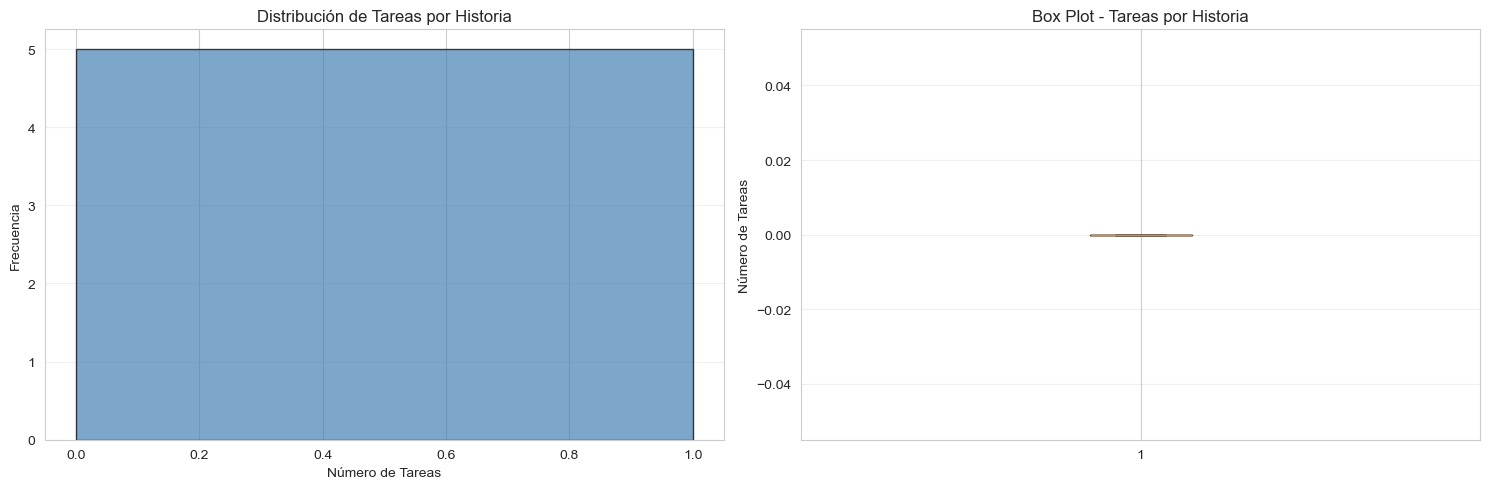

In [ ]:
if len(successful) > 0:
    # Estadísticas
    print("📊 ESTADÍSTICAS")
    print("="*80)
    print(f"\nTotal de tareas generadas: {successful['num_tasks'].sum()}")
    print(f"\nDistribución por historia:")
    print(f"  Mínimo: {successful['num_tasks'].min()} tareas")
    print(f"  Máximo: {successful['num_tasks'].max()} tareas")
    print(f"  Media: {successful['num_tasks'].mean():.2f} tareas")
    print(f"  Mediana: {successful['num_tasks'].median():.0f} tareas")
    print(f"  Desv. Std: {successful['num_tasks'].std():.2f}")
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histograma
    axes[0].hist(successful['num_tasks'], 
                 bins=range(successful['num_tasks'].min(), successful['num_tasks'].max()+2),
                 edgecolor='black', alpha=0.7, color='steelblue')
    axes[0].set_xlabel('Número de Tareas')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title('Distribución de Tareas por Historia')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Box plot
    axes[1].boxplot(successful['num_tasks'], vert=True)
    axes[1].set_ylabel('Número de Tareas')
    axes[1].set_title('Box Plot - Tareas por Historia')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 10. Exportar Resultados

In [ ]:
if len(successful) > 0:
    # Formato "plano" donde cada tarea es una fila
    export_rows = []
    
    for idx, row in successful.iterrows():
        us_data = json.loads(row['input'])
        
        for task in row['tasks_parsed']:
            export_rows.append({
                'user_story_id': idx,
                'project': us_data['project'],
                'user_story_summary': us_data['summary'],
                'user_story_description': us_data['description'],
                'task_number': task['task_number'],
                'task_summary': task['summary'],
                'task_description': task['description']
            })
    
    export_df = pd.DataFrame(export_rows)
    
    print(f"📊 Dataset preparado para exportación:")
    print(f"   Filas (tareas individuales): {len(export_df)}")
    print(f"   Columnas: {list(export_df.columns)}")
    
    display(export_df.head(10))

📊 Dataset preparado para exportación:
   Filas (tareas individuales): 0
   Columnas: []


""


In [ ]:
if len(successful) > 0:
    # Exportar a CSV
    csv_path = "../data/user_stories_with_tasks.csv"
    export_df.to_csv(csv_path, index=False)
    print(f"✅ CSV: {csv_path}")
    
    # Exportar a Excel
    excel_path = "../data/user_stories_with_tasks.xlsx"
    export_df.to_excel(excel_path, index=False, engine='openpyxl')
    print(f"✅ Excel: {excel_path}")
    
    # Exportar resultado raw
    raw_path = "../data/pipeline_raw_output.csv"
    result_df.to_csv(raw_path, index=False)
    print(f"✅ Raw: {raw_path}")
    
    print(f"\n💾 Archivos exportados exitosamente")

## 11. Resumen Final

In [ ]:
print("\n" + "="*80)
print("📋 RESUMEN FINAL")
print("="*80)

print(f"\n📥 Input:")
print(f"   Historias procesadas: {len(df)}")

print(f"\n⚙️ Procesamiento:")
print(f"   Modelo: {CONFIG['model_name']}")
print(f"   Tasa de éxito: {len(successful)/len(result_df)*100:.1f}%")

if len(successful) > 0:
    print(f"\n📤 Output:")
    print(f"   Tareas generadas: {successful['num_tasks'].sum()}")
    print(f"   Promedio: {successful['num_tasks'].mean():.2f} tareas/historia")

print(f"\n💾 Archivos:")
print(f"   • CSV: ../data/user_stories_with_tasks.csv")
print(f"   • Excel: ../data/user_stories_with_tasks.xlsx")
print(f"   • Raw: ../data/pipeline_raw_output.csv")

if len(failed) > 0:
    print(f"\n⚠️ Errores:")
    print(f"   {len(failed)} historias fallaron - revisar ../failures/")

print("\n" + "="*80)
print("✅ PIPELINE COMPLETADO")
print("="*80)

## 🎯 Siguientes Pasos

### Para mejorar resultados:
1. **Ajustar prompt**: Modificar `create_task_generation_prompt()` para más especificidad
2. **Probar modelos**: Cambiar `model_name` (llama3, mistral, codellama)
3. **Ajustar temperatura**: Valores más bajos (0.5) = más deterministico
4. **Aumentar tokens**: `num_predict` si las tareas se cortan

### Para procesar más datos:
1. Cargar CSV con tu dataset real
2. Ajustar `batch_size` según tu hardware
3. Usar cache para iteraciones rápidas
4. Procesar en chunks si dataset es muy grande